In [1]:
!pip install pytorch_lightning==1.9.5 torchmetrics wandb transformers --q

In [2]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

from IPython.display import clear_output
clear_output()

In [3]:
from itertools import groupby
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
import pytorch_lightning as pl

import numpy as np
import pandas as pd
import sys

import matplotlib
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class CFG:
    wandb = False
    model = 'CRNN-with-scheduler-16prec'
    batch_size = 512
    learning_rate = 3e-4
    eps=1e-6
    betas=(0.9, 0.999)
    num_cycles = 0.5

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/lab

/content/drive/MyDrive/lab


In [7]:
blank = ["-"]
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
             "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [8]:
class Dictionary:
    def __init__(self):
        self.char2idx = {}
        self.idx2char = []

    def add_char(self, char: str):
        if char not in self.char2idx:
            self.idx2char.append(char)
            self.char2idx[char] = len(self.idx2char) - 1

    def __len__(self):
        return len(self.idx2char)

In [9]:
dictionary = Dictionary()

for char in blank + provinces + alphabets + numbers:
    dictionary.add_char(char)

In [10]:
class LabelConverter:
    def __init__(self, dictionary: Dictionary):
        self.dictionary = dictionary

    def encode(self, label: str):
        return torch.LongTensor([self.dictionary.char2idx[char] for char in label])

    def decode(
        self,
        sequence,
        prediction = True,
        blank = 0,
    ):

        if prediction:
            sequence = [int(k) for k, _ in groupby(sequence)]
        return "".join(
            self.dictionary.idx2char[idx] for idx in sequence if idx != blank
        )

In [11]:
class BidirectionalLSTM(nn.Module):
    def __init__(
        self,
        dictionary_size: int,
        ninp: int,
        nhid: int,
        nlayers: int,
    ):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=ninp, hidden_size=nhid, num_layers=nlayers, bidirectional=True
        )
        self.decoder = nn.Linear(2 * nhid, dictionary_size)

        self.dictionary_size = dictionary_size

    def forward(self, input):
        output, _ = self.rnn(input)
        seq_len, batch_size, _ = output.size()
        decoded = self.decoder(output)
        decoded = decoded.view(seq_len, batch_size, self.dictionary_size)
        return decoded


class CRNN(nn.Module):
    def conv_layer(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: int,
        batch_norm = False,
    ):
        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=padding,
                bias=not batch_norm
            )
        ]
        if batch_norm:
            layers.append(nn.BatchNorm2d(num_features=out_channels))
        layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def __init__(self, dictionary_size: int):
        super().__init__()

        self.cnn = nn.Sequential(
            self.conv_layer(
                in_channels=1,
                out_channels=64,
                kernel_size=3,
                padding=1
            ),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_layer(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                padding=1
            ),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_layer(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                padding=1
            ),
            self.conv_layer(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                padding=1
            ),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2),
            self.conv_layer(
                in_channels=256,
                out_channels=512,
                kernel_size=3,
                padding=1,
                batch_norm=True
            ),
            self.conv_layer(
                in_channels=512,
                out_channels=512,
                kernel_size=3,
                padding=1,
                batch_norm=True
            ),
            nn.MaxPool2d(
                kernel_size=(1, 2),
                stride=(2, 1),
                padding=(0, 1)
            ),
            self.conv_layer(
                in_channels=512,
                out_channels=512,
                kernel_size=2,
                padding=0,
                batch_norm=True
            )
        )

        self.rnn = BidirectionalLSTM(
            dictionary_size=dictionary_size, ninp=512, nhid=256, nlayers=2
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn(input)
        map_to_sequence = cnn_out.squeeze(2).permute(2, 0, 1)
        output = self.rnn(map_to_sequence)

        return output

In [12]:
class OCRModule(pl.LightningModule):
    def __init__(
        self,
        learning_rate,
        dictionary_size,
        label_converter,
        config
    ):
        super().__init__()

        self.save_hyperparameters("learning_rate", "dictionary_size")

        self.config = config

        self.learning_rate = learning_rate
        self.dictionary_size = dictionary_size
        self.label_converter = label_converter

        self.model = CRNN(dictionary_size=dictionary_size)

    def forward(self, images):
        return self.model(images)

In [13]:
label_converter = LabelConverter(dictionary)

checkpoint = torch.load("checkpoints/best_v.ckpt", map_location=device)
hyper_parameters = checkpoint["hyper_parameters"]

model = OCRModule(**hyper_parameters, label_converter=label_converter, config=CFG)

model_weights = checkpoint["state_dict"]

model.load_state_dict(model_weights)

<All keys matched successfully>

In [14]:
@torch.inference_mode()
def predict(model, converter, img_path):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(0.5, 0.5)
    ])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = transform(img)

    pred = model(img.unsqueeze(0))

    return converter.decode(pred.argmax(-1))

In [15]:
def draw_sample(img_path: str, model):
    nl = '\n'
    pred = predict(model, label_converter, img_path)
    ground_truth = img_path.split('/')[-1].split('.')[0].split('-')[-1]
    img = cv2.imread(img_path)
    plt.imshow(img, cmap="gray")
    plt.title(f'Predicted: {pred}{nl} True label: {ground_truth}')
    plt.axis("off")

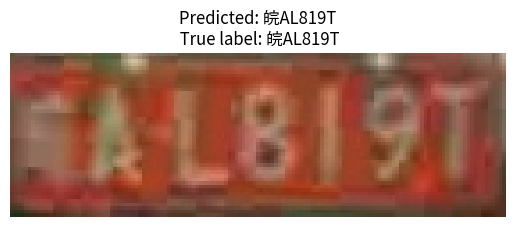

In [19]:
img_path = 'test/0091-皖AL819T.jpg'
draw_sample(img_path, model)